In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from typing import Tuple, List, Dict, Callable
from modules.dataset.dataset import Dataset, Data
from modules.utils.utils import *
from modules.metrics.metrics import *

mnist_dataset = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()
x_train, x_test = normalize_dataset(x_train, x_test)
train = Data(x_train, y_train)
test = Data(x_test, y_test)

dataset = Dataset(train, test)
dataset.build_vf_dataset(proportion_cs=0.5, 
                        proportion_left=0.5, 
                        full_attention_value=1, 
                        reduced_attention_value=0.5, 
                        ss_attention_value=0.5)

In [ ]:
model_dir = '../models/model_t1_denser_50_256/'
model_path = model_dir + 'model.keras'
out_models_dir = model_dir + 'out_models/'

model = tf.keras.models.load_model(model_path)
model.summary()

In [ ]:
a = (None, 2, 5)
(lambda x, y, z: y * z)(*a)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from typing import List, Tuple, Optional
from attr import define
from modules.utils.utils import load_obj, normalize_dataset, get_current_time_string, compute_activations, compute_digits_model_predicts
from collections.abc import Iterable

mnist_dataset = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()
x_train, x_test = normalize_dataset(x_train, x_test)

model = tf.keras.models.load_model('../models/MODELS_TEST_PLOTTER/model_conv.keras')

2024-09-28 13:41:34.673990: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-28 13:41:34.676598: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-28 13:41:34.721569: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-28 13:41:34.721616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-28 13:41:34.724378: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 left_input (InputLayer)     [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 right_input (InputLayer)    [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 left_conv1 (Conv2D)         (None, 28, 28, 1)            10        ['left_input[0][0]']          
                                                                                                  
 right_conv1 (Conv2D)        (None, 28, 28, 1)            10        ['right_input[0][0]']         
                                                                                            

In [ ]:


num_neurons = (None, 28, 28, 1)
nn = int(np.prod([el for el in num_neurons if el is not None]))
print(nn)

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from typing import List, Tuple, Optional, Set
from attr import define
from modules.utils.utils import normalize_ndarray, get_current_time_string, compute_activations, compute_digits_model_predicts
from collections.abc import Iterable

@define
class Position:
    """
    Dataclass representing a position with two coordinates
    """

    x: float
    y: float

    def copy(self):
        return Position(self.x, self.y)

    def __str__(self):
        return f"Position({self.x}, {self.y})"

@define
class PlottedNeuron:
    """
    Dataclass representing a neuron in the Neural Network plot
    """

    activation: float
    position: Position
    radius: float

class PlottedLayer():
    """
    Class representing a layer in the Neural Network plot
    """

    def __init__(self, original_layer: tf.keras.layers.Layer, activations: Optional[List[float]] = None, position:  Optional[Position] = None):
        # Copying necessary attributes from original layer
        self.name = original_layer.name
        self.weights = original_layer.get_weights()
        self.activations = activations
        self.position = position if position is not None else Position(0, 0)
        self.num_neurons = self.__compute_num_neurons(original_layer.output_shape)
        self.neurons = []
        self.type = original_layer.__class__.__name__
        self.is_input_layer = self.type == "InputLayer"
        self.is_output_layer = not bool(original_layer._outbound_nodes)
        self.is_concatenate_layer = self.type == "Concatenate"
        self.previous_layers = self.__get_previous_layers(original_layer)

    def __str__(self):
        return f"PlottedLayer({self.name}, {self.type}, {self.num_neurons}, is_input={self.is_input_layer}, is_output={self.is_output_layer}, is_concat={self.is_concatenate_layer})"
    
    def __compute_num_neurons(self, num_neurons) -> int:
        print(f"COMPUTE NUM NEURONS CALLED ON {self.name}")
        print(num_neurons)
        if (isinstance(num_neurons, Iterable)):
            if len(num_neurons) == 1: num_neurons = num_neurons[0]
            print([el for el in num_neurons if el is not None])
            print(int(np.prod([el for el in num_neurons if el is not None])))
            return int(np.prod([el for el in num_neurons if el is not None]))
        return int(num_neurons)
    
    def __get_previous_layers(self, layer: tf.keras.layers.Layer) -> List[tf.keras.layers.Layer]:
        previous_layers = layer._inbound_nodes[0].inbound_layers
        if type(previous_layers) == list:
            return previous_layers
        return [previous_layers]
    
    def get_previously_plotted_layer(self, plotted_layers: List["PlottedLayer"]) -> Optional["PlottedLayer"]:
        pl_queue = self.previous_layers
        while pl_queue:
            pl = pl_queue.pop(0)
            #print(pl.name, set(map(lambda plt_layer: plt_layer.name, plotted_layers)))
            for plt_layer in plotted_layers:
                if plt_layer.name == pl.name:
                    return plt_layer
            pl_previous_layers = self.__get_previous_layers(pl)
            pl_queue.extend(pl_previous_layers)
            
        return None

@define
class PlottingControl:
    """
    Dataclass representing control variables for plotting the Neural Network
    """

    plotted: List[PlottedLayer] = []
    is_left_vf: bool = False
    has_concatenated: bool = False
    vf_top: float = 0
    vf_bottom: float = 0
    SHOULD_PLOT = {"InputLayer", "Dense", "Concatenate", "Conv2D"}

class NeuralNetworkPlotter:
    def __init__(
            self, 
            model: tf.keras.Model, 
            max_neurons: int = 300,
            weight_threshold: float = 0.5,
            attribute_lenses: Optional[List[tf.keras.Model]] = None,
            num_attr_lenses_top_activations: int = 3,
            save_plots: bool = True,
            ) -> None:
        
        self.model = model
        self.max_neurons = max_neurons
        self.weight_threshold = weight_threshold
        self.attribute_lenses = attribute_lenses
        self.num_attr_lenses_top_activations = num_attr_lenses_top_activations
        self.save_plots = save_plots
        self.__controller = None

    # Single visual field plot function
    def plot(self, data: np.array) -> None:
        pass

    # Double visual field plot function
    def plot(self, 
             left_vf_data: np.array, 
             right_vf_data: np.array,
             model: Optional[tf.keras.Model] = None,
             max_neurons: Optional[int] = None,
             weight_threshold: Optional[float] = None,
             attribute_lenses: Optional[List[tf.keras.Model]] = None,
             num_attr_lenses_top_activations: Optional[int] = None,
             save_plot: Optional[bool] = None) -> None:
        
        """
        Receives a trained model with two visual fields and an input, displaying the entire neural network with its
        activations for that input.

        Observation: the attention value for each visual field is applied in the function input data

        Input: 
        model: tf.keras.Model: model to be used for visualization
        left_vf_data: np.array: left visual field data
        right_vf_data: np.array: right visual field data
        max_neurons: int: maximum number of neurons to be plotted in a layer (default: 300)
        weight_threshold: float: minimum weight value to be plotted, considering normalized values between 0 and 1 (default: 0.5)
        attribute_lenses: Optional[List[tf.keras.Model]]: list of models to be used as attribute lenses for each layer (default: None)
        num_attr_lenses_top_activations: int: number of top digit activations displayed for each attribute lens (default: 3)
        save_plot: bool: if the neural network plot should be saved as an image (default: True)

        Output:
        displays and saves the image in results/images/ if requested
        """
        
        # Setting default values
        if model is None:
            model = self.model
        if max_neurons is None:
            max_neurons = self.max_neurons
        if weight_threshold is None:
            weight_threshold = self.weight_threshold
        if attribute_lenses is None:
            attribute_lenses = self.attribute_lenses
        if num_attr_lenses_top_activations is None:
            num_attr_lenses_top_activations = self.num_attr_lenses_top_activations
        if save_plot is None:
            save_plot = self.save_plots

        # Determining matplotlib figure parameters
        fig = plt.figure(figsize=(48, 24))
        ax = fig.gca()
        ax.axis("off")
        top, bottom, left, right = self.__compute_figure_sizes(top=0.98)
        middle = round((top + bottom) / 2, ndigits=4)
        MIDDLE_SPACING = 0.02

        # Calculating neural network activations
        model_activations = compute_activations(model, left_vf_data, right_vf_data)

        # Determining neural network figure parameters
        CONECTION_OPACITY = 0.2
        COLOR_CONECTION_OPACITY = 0.5
        LEFT_VF_MIDDLE = 1.5 * middle
        RIGHT_VF_MIDDLE = 0.5 * middle
        INITIAL_LEFT_VF_POSITION = Position(left, 1.5 * middle) 
        INITIAL_RIGHT_VF_POSITION = Position(left, 0.5 * middle)  
        model_number_of_layers = len(model.layers)

        # Setting up control structure to plot layers
        self.__controller = PlottingControl()
        for i, (layer, activations) in enumerate(zip(model.layers, model_activations)):
            plotted_layer = PlottedLayer(original_layer=layer, activations=activations)
            if plotted_layer.type not in self.__controller.SHOULD_PLOT: continue # only plots layers that should be plotted
            # Determining layer characteristics
            self.__controller.is_left_vf = i % 2 == 0 and not (plotted_layer.is_concatenate_layer or self.__controller.has_concatenated)
            self.__controller.vf_top = top
            self.__controller.vf_bottom = bottom
            # Left VF
            if self.__controller.is_left_vf:
                self.__controller.vf_bottom = middle + MIDDLE_SPACING
            # Right VF
            elif not (plotted_layer.is_concatenate_layer or self.__controller.has_concatenated):
                self.__controller.vf_top = middle - MIDDLE_SPACING
            # Input
            if plotted_layer.is_input_layer:
                plotted_layer.position = INITIAL_LEFT_VF_POSITION if self.__controller.is_left_vf else INITIAL_RIGHT_VF_POSITION
                ab = self.__generate_image_annotation_box(
                            plotted_layer.activations,
                            plotted_layer.position,
                            cmap="binary",
                            size=self.__calculate_image_size(plotted_layer.num_neurons),
                        )
                ax.add_artist(ab)
                self.__controller.plotted.append(plotted_layer)
                continue
            # Conv2D
            if plotted_layer.type == "Conv2D":
                if self.__controller.has_concatenated:
                    plotted_layer.position.y = middle
                else:
                    plotted_layer.position.y = LEFT_VF_MIDDLE if self.__controller.is_left_vf else RIGHT_VF_MIDDLE
            # Concatenate
            if plotted_layer.is_concatenate_layer:
                self.__controller.has_concatenated = True
            # Output
            if plotted_layer.is_output_layer:
                output_offset = 0.2
                self.__controller.vf_top = middle + output_offset
                self.__controller.vf_bottom = middle - output_offset
                        
            # Getting previosuly plotted layer
            layer_spacing = 0.05 if len(self.__controller.plotted) < 4 else 1.3 / (model_number_of_layers-4) # adjust layer spacing based on current layer
            previous_layer = plotted_layer.get_previously_plotted_layer(self.__controller.plotted)
            print(plotted_layer.name, previous_layer.name)
            plotted_layer.position.x = previous_layer.position.x + layer_spacing

            print(plotted_layer.num_neurons, max_neurons)
            if plotted_layer.num_neurons <= max_neurons:
                plotted_layer.position.y = self.__controller.vf_top
                print(self.__controller.vf_top, self.__controller.vf_bottom)
                neuron_spacing = (self.__controller.vf_top - self.__controller.vf_bottom) / plotted_layer.num_neurons
                neuron_position = plotted_layer.position.copy()
                layer_activations = normalize_ndarray(plotted_layer.activations) if not plotted_layer.is_output_layer else plotted_layer.activations
                for j, neuron_activation in enumerate(layer_activations):
                    neuron = PlottedNeuron(neuron_activation, position=neuron_position.copy(), radius=neuron_spacing/4)
                    plotted_layer.neurons.append(neuron)
                    neuron_circle = plt.Circle(
                        xy=(neuron.position.x, neuron.position.y),
                        radius=neuron.radius,
                        color=plt.cm.viridis(neuron_activation),
                        ec="k",
                    )
                    ax.add_artist(neuron_circle)
                    neuron_position.y -= neuron_spacing
            else:
                ab = self.__generate_image_annotation_box(
                            plotted_layer.activations,
                            plotted_layer.position,
                            cmap="binary",
                            size=self.__calculate_image_size(plotted_layer.num_neurons),
                        )
                ax.add_artist(ab)
            
            self.__controller.plotted.append(plotted_layer) # add current layer to plotted layers list
        plt.show()

    def __compute_figure_sizes(self, top: float) -> List[float]:
        """
        Computes sizes of the figure based on the top percentage of the figure
        """
        bottom = 1 - top
        return top, bottom, bottom, top
    
    def __generate_image_annotation_box(
        self, image: np.array, position: Position, size: int, cmap="binary", border_width: int = 1, border_color: str = "black"
    ) -> AnnotationBbox:
        """
        Generates the AnnotationBbox of the grayscale image with a border to be positioned in the figure
        """

        img = OffsetImage(
            image, zoom=size, cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1)
        )
        ab = AnnotationBbox(
            img,
            (position.x, position.y),
            frameon=True,
            pad=0,
            bboxprops=dict(
                edgecolor=border_color, linewidth=border_width, boxstyle="square,pad=0.1"
            ),
        )

        return ab
    
    def __get_image(self, neural_activation: np.array):
        """
        Transforms 1D array into 2D array to be plotted as an image
        """
        num_neurons = len(neural_activation)
        num_rows = int(np.sqrt(num_neurons))
        num_cols = int(np.ceil(num_neurons / num_rows))

        return np.array(neural_activation).reshape(num_rows, num_cols)

    def __get_digit_from_y_spacing(self, total_position_plotted: float, y_spacing: float) -> int:
        """
        Returns the digit an output neuron represents based on how many neurons have been plotted
        """
        return np.ceil(total_position_plotted / y_spacing)

    def __calculate_image_size(self, number_neurons: int) -> float:
        """
        Computes size of image based on the number of neurons
        """
        # Determined in tests
        a = -5/1536
        b = 533/96
        return number_neurons * a + b

    def generate_output_models(self, model: Optional[tf.keras.Model] = None) -> List[tf.keras.Model]:
        """
        Generates output models for each hidden layer of the model
        """
        if model is None:
            model = self.model
        
        # Generate not trainable copy of model
        model_copy = tf.keras.models.clone_model(model)
        model_weights = model.get_weights()
        model_copy.set_weights(model_weights)
        for layer in model_copy.layers:
            layer.trainable = False 
        
        # Generate output models of each hidden layer
        output_models = []
        for layer in model_copy.layers[4:-2]:
            out_model_input = model_copy.input # [left_input, right_input]
            if 'left' in layer.name:
                out_model_input = out_model_input[0]
            elif 'right' in layer.name:
                out_model_input = out_model_input[1]
                
            out_model_output = tf.keras.layers.Dense(10, activation="softmax")(layer.output)
            out_model = tf.keras.models.Model(
            inputs=out_model_input, outputs=out_model_output
            )
            output_models.append(out_model)

        return output_models

COMPUTE NUM NEURONS CALLED ON left_input
[(None, 28, 28, 1)]
[28, 28, 1]
784
COMPUTE NUM NEURONS CALLED ON right_input
[(None, 28, 28, 1)]
[28, 28, 1]
784
COMPUTE NUM NEURONS CALLED ON left_conv1
(None, 28, 28, 1)
[28, 28, 1]
784
left_conv1 left_input
784 300
COMPUTE NUM NEURONS CALLED ON right_conv1
(None, 28, 28, 1)
[28, 28, 1]
784
right_conv1 right_input
784 300
COMPUTE NUM NEURONS CALLED ON left_flatten
(None, 784)
[784]
784
COMPUTE NUM NEURONS CALLED ON right_flatten
(None, 784)
[784]
784
COMPUTE NUM NEURONS CALLED ON left_dense1
(None, 32)
[32]
32
left_dense1 left_conv1
32 300
0.98 0.52
COMPUTE NUM NEURONS CALLED ON right_dense1
(None, 32)
[32]
32
right_dense1 right_conv1
32 300
0.48 0.020000000000000018
COMPUTE NUM NEURONS CALLED ON left_dense2
(None, 32)
[32]
32
left_dense2 left_dense1
32 300
0.98 0.52
COMPUTE NUM NEURONS CALLED ON right_dense2
(None, 32)
[32]
32
right_dense2 right_dense1
32 300
0.48 0.020000000000000018
COMPUTE NUM NEURONS CALLED ON concatenate
(None, 64)
[64]

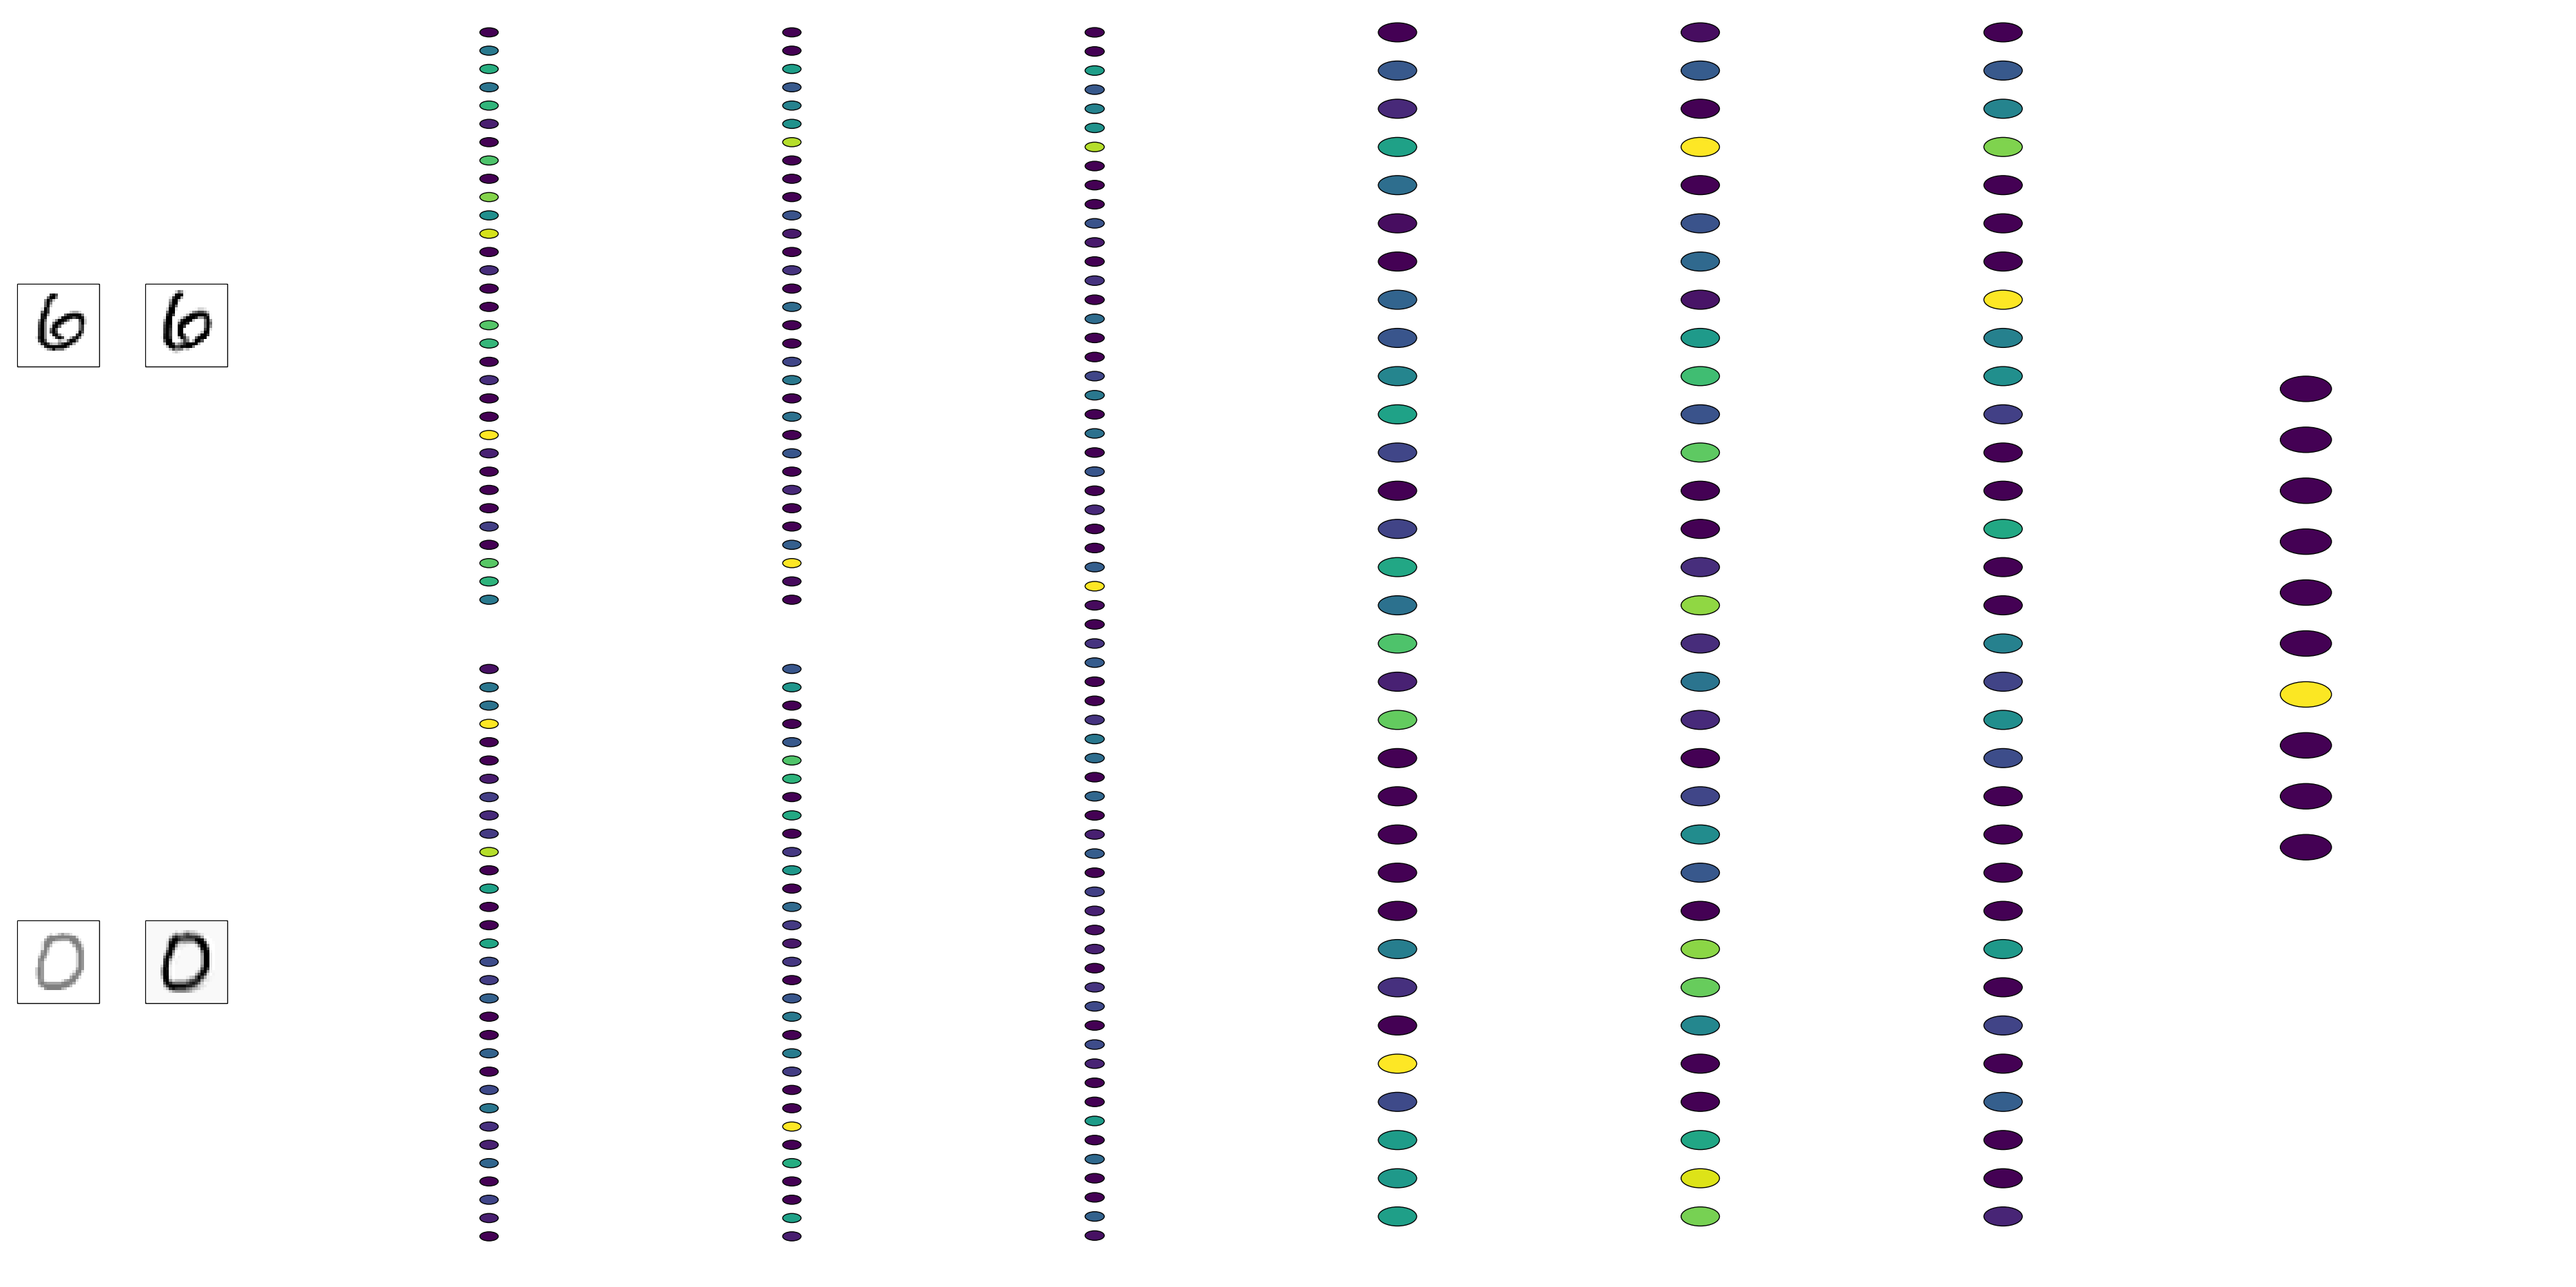

In [22]:
plotter = NeuralNetworkPlotter(model)
plotter.plot(x_test[11], x_test[10] * 0.5)

In [6]:
actv = compute_activations(model, x_test[11], x_test[10] * 0.5)
[el.shape for el in actv]

[TensorShape([28, 28, 1]),
 TensorShape([28, 28, 1]),
 TensorShape([28, 28, 1]),
 TensorShape([28, 28, 1]),
 TensorShape([784]),
 TensorShape([784]),
 TensorShape([32]),
 TensorShape([32]),
 TensorShape([32]),
 TensorShape([32]),
 TensorShape([64]),
 TensorShape([32]),
 TensorShape([32]),
 TensorShape([32]),
 TensorShape([10])]

In [12]:
lrs = model.layers
[(lr.name, lr.output_shape) for lr in lrs]

[('left_input', [(None, 28, 28, 1)]),
 ('right_input', [(None, 28, 28, 1)]),
 ('left_conv1', (None, 28, 28, 1)),
 ('right_conv1', (None, 28, 28, 1)),
 ('left_flatten', (None, 784)),
 ('right_flatten', (None, 784)),
 ('left_dense1', (None, 32)),
 ('right_dense1', (None, 32)),
 ('left_dense2', (None, 32)),
 ('right_dense2', (None, 32)),
 ('concatenate', (None, 64)),
 ('drf_dense1', (None, 32)),
 ('drf_dense2', (None, 32)),
 ('drf_dense3', (None, 32)),
 ('output', (None, 10))]